# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [63]:
import player_data as player
import pandas as pd
import patsy
import numpy as np
import itertools
from sklearn.svm import SVR
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_2019-05-14.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name, index_col=0)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
player.add_home_categorical_variable(element_gameweek_df)

In [9]:
element_gameweek_df.head()

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,team_a,team_a_difficulty,team_h,team_h_difficulty,element_type,team,web_name,safe_web_name,own_team,opposition_team
0,0,0,42,0,0,0,24,0,2,31,...,13,4,1,4,1,1,Cech,cech,1,13
1,1,0,35,0,0,0,26,0,1,25,...,1,4,6,4,1,1,Cech,cech,1,6
2,2,0,24,0,0,0,17,0,0,20,...,19,4,1,3,1,1,Cech,cech,1,19
3,3,0,38,0,0,0,8,0,0,24,...,1,2,5,4,1,1,Cech,cech,1,5
4,4,0,33,0,0,0,13,0,2,23,...,1,3,15,4,1,1,Cech,cech,1,15


In [10]:
cols = [
    'element',
    'event',
    'own_team',
    'opposition_team',
    'was_home',
    'element_type',
    'value',
    'total_points',
    'minutes'
]

rolling_cols = ['total_points']

In [11]:
element_gameweek_df = element_gameweek_df[cols]
element_gameweek_df['element_fixture_rank'] = element_gameweek_df.groupby('element')['event'].rank()
element_gameweek_df.head()

,element,event,own_team,opposition_team,was_home,element_type,value,total_points,minutes,element_fixture_rank
0,1,1,1,13,1,1,50,3,90,1.0
1,1,2,1,6,0,1,50,3,90,2.0
2,1,3,1,19,1,1,50,3,90,3.0
3,1,4,1,5,0,1,50,1,90,4.0
4,1,5,1,15,0,1,50,2,90,5.0


# Modelling data

## Splitting data

In [12]:
last_train_event = 15

In [13]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [14]:
formula = \
'total_points ~ C(element) + C(element_type) + C(own_team) + value + C(opposition_team) + was_home'

In [15]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [16]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Scaling data

## Tuning model

In [87]:
rbf_gamma = [0.075, 0.1, 0.125]
rbf_C = [4.5, 5, 5.5]
rbf_epsilon = [0.75, 1, 1.25]

rbf_parameters = {
    'gamma': rbf_gamma,
    'C': rbf_C,
    'epsilon': rbf_epsilon
}

In [88]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_rbf.fit(X, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 18.0min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [4.5, 5, 5.5], 'epsilon': [0.75, 1, 1.25],
                         'gamma': [0.075, 0.1, 0.125]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [89]:
pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon','param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,4.5,0.75,0.075,-1.391895,-5.891085
1,4.5,0.75,0.1,-1.398726,-5.910031
2,4.5,0.75,0.125,-1.408045,-5.934183
3,4.5,1,0.075,-1.474941,-5.878072
4,4.5,1,0.1,-1.475760,-5.889931
5,4.5,1,0.125,-1.481240,-5.909532
6,4.5,1.25,0.075,-1.564373,-5.900805
7,4.5,1.25,0.1,-1.565384,-5.906666
8,4.5,1.25,0.125,-1.571780,-5.933970
9,5,0.75,0.075,-1.391906,-5.888238


In [90]:
linear_C = [10, 15, 20]
linear_epsilon = [0.65, 0.75, 0.85]

linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [91]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X, y.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.1min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [10, 15, 20], 'epsilon': [0.65, 0.75, 0.85]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [92]:
pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,10,0.65,-1.421759,-5.974157
1,10,0.75,-1.443970,-5.969011
2,10,0.85,-1.474931,-5.953235
3,15,0.65,-1.421744,-5.974215
4,15,0.75,-1.443935,-5.969038
5,15,0.85,-1.456420,-5.925539
6,20,0.65,-1.421732,-5.974005
7,20,0.75,-1.443965,-5.968894
8,20,0.85,-1.459330,-5.928819


## Evaluating model

In [48]:
model = SVR(kernel='rbf', gamma=0.1, C=3, epsilon=1)
model.fit(X_train, y_train.ravel())

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [49]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred))
test_loss

(1.4825890141854317, 5.912900997992636)

In [ ]:
pd.Series(y_pred).describe()

In [52]:
# refit model on all data
model_full = SVR(kernel='rbf', gamma=0.1, C=3, epsilon=1)
model_full.fit(X, y.ravel())

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [53]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (mean_absolute_error(y, y_pred_full), mean_squared_error(y, y_pred_full))
test_loss_full

(1.2799846400708326, 4.467479442439563)

In [54]:
pd.Series(y_pred_full).describe()

count    10961.000000
mean         1.387047
std          0.914710
min         -0.376974
25%          0.835177
50%          1.000184
75%          1.795558
max          9.343333
dtype: float64

In [66]:
abs(pd.Series(y.ravel()) - pd.Series(y_pred_full)).describe()

count    10961.000000
mean         1.279985
std          1.682075
min          0.000023
25%          0.583660
50%          0.889226
75%          1.000266
max         18.335771
dtype: float64

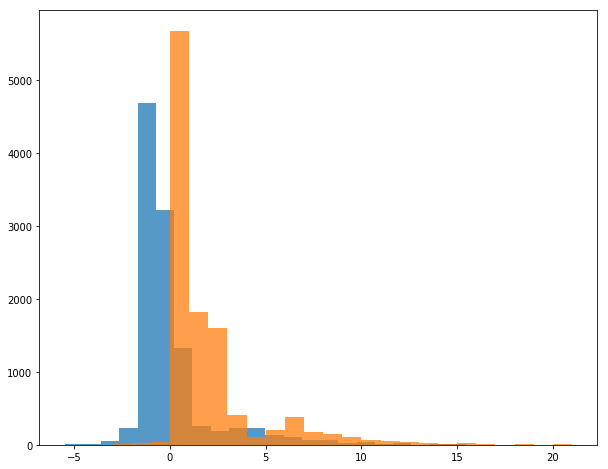

In [72]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y.ravel()) - pd.Series(y_pred_full), bins=25, alpha=0.75)
plt.hist(pd.Series(y.ravel()), bins=25, alpha=0.75)
plt.show()

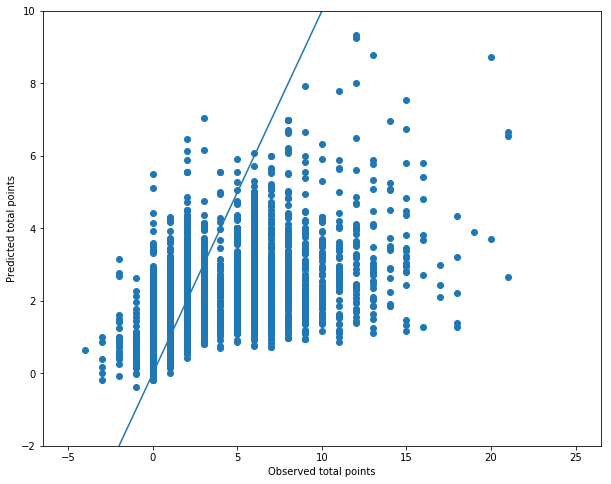

In [86]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(y_pred_full))
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-2, 10))
plt.show()